## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from feature_engine.outlier_removers import Winsorizer
from feature_engine.categorical_encoders import MeanCategoricalEncoder
from feature_engine import variable_transformers as vt

######## Feature selection packages 

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### models implemented
from catboost import CatBoostRegressor

pd.pandas.set_option('display.max_columns', None)

### Load Datasets

In [2]:
# load dataset
data = pd.read_csv('houseprice.csv')
### drop the Id 
data.drop('Id', axis=1, inplace=True)
print(data.shape)
data.dtypes.unique()

(1460, 80)


array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

There are a mixture of categorical and numerical variables. Numerical are those of type **int** and **float** and categorical those of type **object**.

#### Find temporal variables

There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables:


In [3]:
# list of variables that contain year information
year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

print(year_vars)

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

for var in data[year_vars].columns:
    elapsed_years(data,var)



data.drop('YrSold',axis=1,inplace=True)
year_vars.remove('YrSold')

print(data[year_vars].head(3))
data[year_vars].dtypes

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
   YearBuilt  YearRemodAdd  GarageYrBlt
0          5             5          5.0
1         31            31         31.0
2          7             6          7.0


YearBuilt         int64
YearRemodAdd      int64
GarageYrBlt     float64
dtype: object

# get the categorical features

In [4]:
# find categorical variables
discrete= [ var for var in data.columns   if data[var].dtype != 'O' and var!='SalePrice' and data[var].nunique() < 15 ]
numerical= [ var for var in data.columns     if data[var].dtype != 'O' and var!='SalePrice' and var not in discrete]
categorical = [var for var in data.columns if data[var].dtype =='O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} numerical variables'.format(len(numerical)))
print('There are {} categorical variables'.format(len(categorical)))

There are 13 discrete variables
There are 22 numerical variables
There are 43 categorical variables


In [5]:
# let's visualise the values of the discrete variables
for ft in data[discrete]:
    print(ft, "   " , data[ft].unique())

OverallQual     [ 7  6  8  5  9  4 10  3  1  2]
OverallCond     [5 8 6 7 4 2 3 9 1]
BsmtFullBath     [1 0 2 3]
BsmtHalfBath     [0 1 2]
FullBath     [2 1 3 0]
HalfBath     [1 0 2]
BedroomAbvGr     [3 4 1 2 0 5 6 8]
KitchenAbvGr     [1 2 3 0]
TotRmsAbvGrd     [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces     [0 1 2 3]
GarageCars     [2 3 1 0 4]
PoolArea     [  0 512 648 576 555 480 519 738]
MoSold     [ 2  5  9 12 10  8 11  4  1  7  3  6]


In [6]:
for ft in data[categorical]:
    print(ft, "   " , data[ft].unique())

MSZoning     ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street     ['Pave' 'Grvl']
Alley     [nan 'Grvl' 'Pave']
LotShape     ['Reg' 'IR1' 'IR2' 'IR3']
LandContour     ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities     ['AllPub' 'NoSeWa']
LotConfig     ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope     ['Gtl' 'Mod' 'Sev']
Neighborhood     ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1     ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2     ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType     ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle     ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle     ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl     ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' '

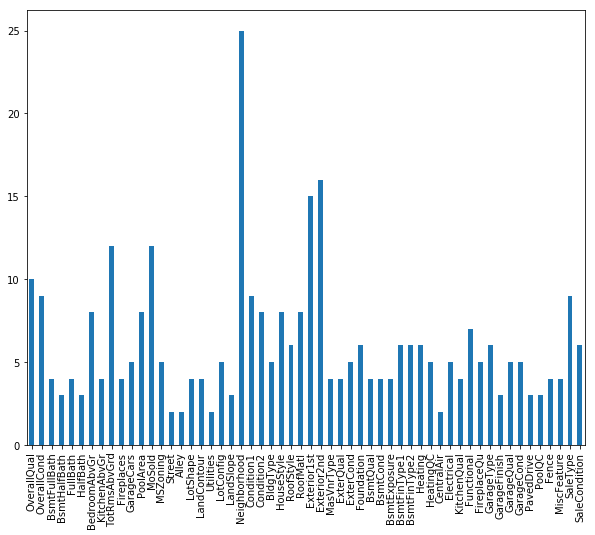

In [7]:
data[discrete+categorical].nunique().plot.bar(figsize=(10,8))

#### Continuous variables

### Separate train and test set

In [8]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 78), (146, 78))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

## Putting it all together

In [9]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [10]:
house_pipe = Pipeline([

    # missing data imputation 
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                        variables= numerical)),
    
    ('imputer_cat', 
     mdi.CategoricalVariableImputer(variables=categorical)),
    
    ##### REMOVE OUTLIERS##############
    ('outlier_rem',
     Winsorizer(distribution='skewed',
                             tail='both',
                             fold=2.0,
                             variables=numerical)),
    ####################################
    # categorical encoding 
    ('rare_label_enc', 
         ce.RareLabelCategoricalEncoder(
        tol=0.05, n_categories=6, variables=categorical+discrete)),
    ('categorical_encoder',
     MeanCategoricalEncoder( variables = categorical + discrete)
    ),
    # regression
    #('regression',
    # CatBoostRegressor(max_depth= 6 ,learning_rate=0.01))
]) 

In [11]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
#X_train_preds = house_pipe.predict(X_train)
#X_test_preds = house_pipe.predict(X_test)

Pipeline(memory=None,
         steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='median',
                                   variables=['MSSubClass', 'LotFrontage',
                                              'LotArea', 'YearBuilt',
                                              'YearRemodAdd', 'MasVnrArea',
                                              'BsmtFinSF1', 'BsmtFinSF2',
                                              'BsmtUnfSF', 'TotalBsmtSF',
                                              '1stFlrSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'GarageYrBlt', 'GarageArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'EnclosedPorch', '3S...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandS

# FEATURE SELECTION

In [12]:
X_train_fe = house_pipe.transform(X_train)
X_test_fe = house_pipe.transform(X_test)

print (X_train_fe.shape)
print(X_test_fe.shape)

type(X_train_fe)

(1314, 78)
(146, 78)


pandas.core.frame.DataFrame

In [13]:
sel = VarianceThreshold(threshold=0.05)  # 0.1 indicates 99% of observations approximately
 
sel.fit(X_train_fe)  # fit finds the features with low variance
 
print("We are keeping total of {} features".format(sum(sel.get_support())) )

features_to_keep = X_train_fe.columns[sel.get_support()]  ### put the low variance features in a list


X_train_fe = sel.transform(X_train_fe)
X_test_fe = sel.transform(X_test_fe)

X_train_fe= pd.DataFrame(X_train_fe)
X_train_fe.columns = features_to_keep
 
X_test_fe= pd.DataFrame(X_test_fe)
X_test_fe.columns = features_to_keep

We are keeping total of 72 features


In [14]:
#### remove correlated features 
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train_fe, 0.9)
print('correlated features: ', len(set(corr_features)) )

X_train_fe.drop(labels=corr_features, axis=1, inplace=True)
X_test_fe.drop(labels=corr_features, axis=1, inplace=True)

X_train_fe = pd.DataFrame(X_train_fe)
X_test_fe = pd.DataFrame(X_test_fe)

X_train_fe.shape, X_test_fe.shape

correlated features:  3


((1314, 69), (146, 69))

In [ ]:
######## Feature selection with random forest 
sel_ = SelectFromModel(RandomForestRegressor(max_depth = 4 , n_estimators=300 , random_state=0))
sel_.fit(X_train_fe, y_train)

In [18]:
# check model performance:           
print('train mae: {}'.format(mean_absolute_error(y_train, X_train_preds) , 2) )
print('train r2: {}'.format(r2_score(y_train, X_train_preds),2))
print()
print('test mae: {}'.format(mean_absolute_error(y_test, X_test_preds),2) )
print('test r2: {}'.format(r2_score(y_test, X_test_preds),2))

train mae: 11204.553506067026
train r2: 0.963311285713026

test mae: 16583.527594705927
test r2: 0.8681195327486687


Text(0, 0.5, 'Predicted Price')

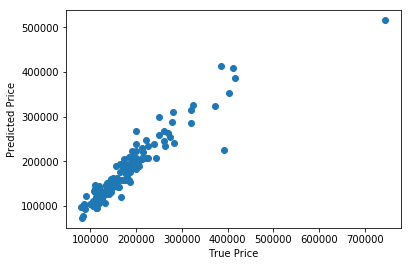

In [15]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')